I downloaded the data from the scDesign3 [quickstart](https://songdongyuan1994.github.io/scDesign3/docs/articles/scDesign3.html). There are only 100 genes in this demo.

In [1]:
import anndata
import os
import requests

save_path = "data/example_sce.h5ad"
if not os.path.exists(save_path):
    response = requests.get("https://go.wisc.edu/69435h")
    with open(save_path, "wb") as f:
        f.write(response.content)

example_sce = anndata.read_h5ad(save_path)
example_sce

AnnData object with n_obs × n_vars = 2087 × 100
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'cell_type', 'sizeFactor', 'pseudotime'
    var: 'highly_variable_genes'
    uns: 'X_name', 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'PCA', 'UMAP', 'X_pca', 'X_umap'
    layers: 'counts', 'cpm', 'logcounts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

The result seems quite sensitive to the learning rate. How can we pick a good default? Maybe we can systematically survey good lr's across a range of public data. Alternatively, is there a good way to adapt during learning?

In [2]:
from scdesigner.simulators import NegBinCopulaSimulator
import numpy as np

sim = NegBinCopulaSimulator()
sim.fit(example_sce, "~ pseudotime")
sim

scDesigner simulator object with
    method: NegBinCopulaSimulator
    formula: ~ pseudotime
    parameters: coef_mean [2x100], coef_dispersion [1x100], covariance [100x100]

In [3]:
sim.predict(example_sce.obs)

{'mean':                         Pyy       Iapp       Chgb       Rbp4       Spp1  \
 AAACCTGAGAGGGATA  34.091239  26.227679  22.176244  14.473243   0.505738   
 AAACCTGGTAAGTGGC  19.649555  15.624163  13.110461   8.345394   2.081455   
 AAACGGGCAAAGAATC  40.078063  30.536333  25.877126  17.012948   0.333813   
 AAACGGGGTACAGTTC  59.484440  44.263479  37.715056  25.243735   0.121099   
 AAACGGGGTGAAATCA  17.516971  14.024595  11.749570   7.440272   2.795649   
 ...                     ...        ...        ...        ...        ...   
 TTTGGTTTCACTTACT   9.414114   7.822710   6.497735   4.000387  13.770749   
 TTTGGTTTCCTTTCGG  44.194597  33.476264  28.406843  18.759085   0.259699   
 TTTGTCAAGAATGTGT  35.798066  27.460365  23.234196  15.197336   0.446114   
 TTTGTCAAGTGACATA  28.078398  21.854200  18.428858  11.922179   0.832362   
 TTTGTCAAGTGTGGCA  15.518311  12.514859  10.467200   6.591919   3.815791   
 
                        Chga        Cck       Ins1       Nnat       Ins2  ... 

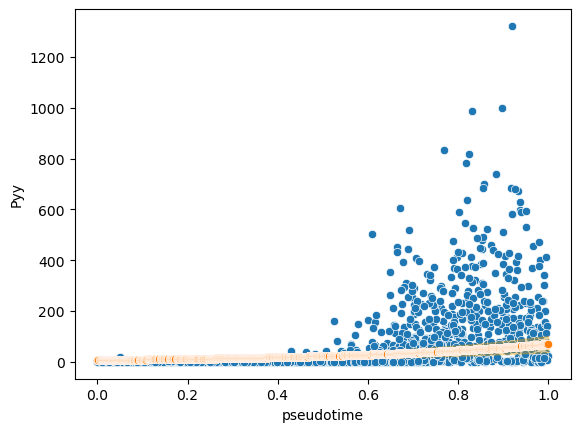

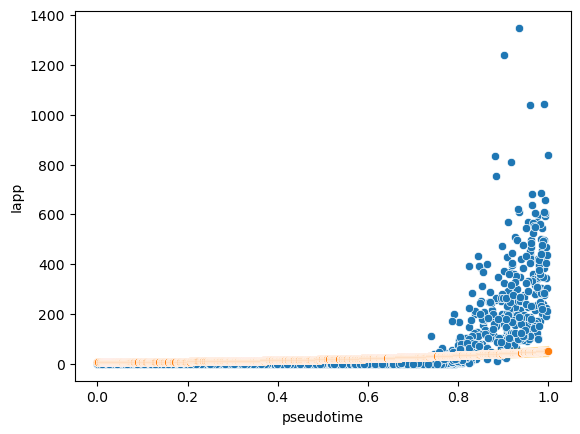

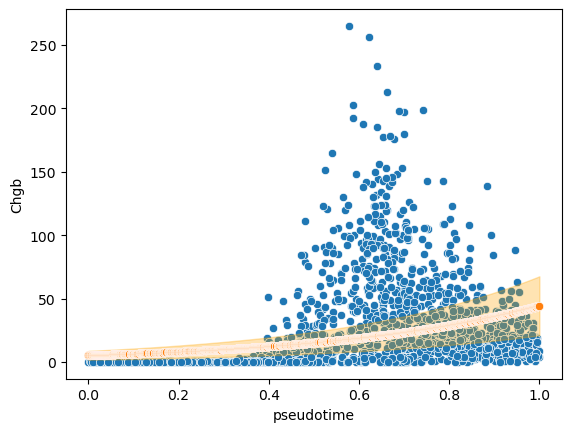

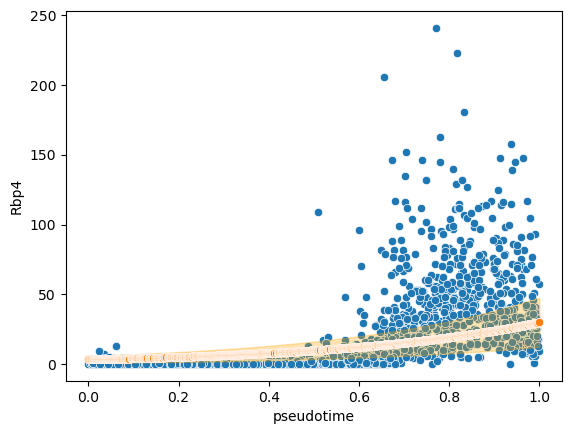

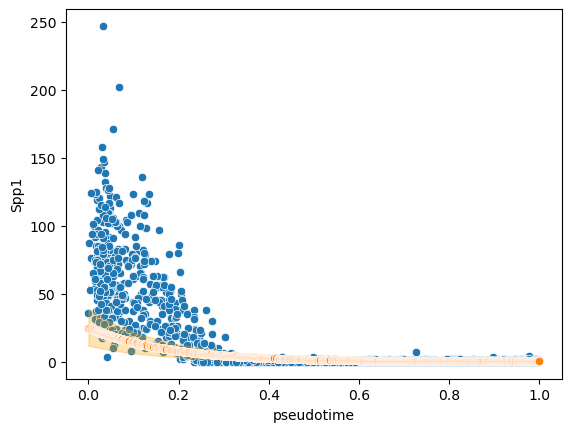

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_gene(sim, example_sce, ix=0):
    # get predictions
    gene = example_sce.var_names[ix]
    y_hat = sim.predict(example_sce.obs)["mean"]
    variance = y_hat + (y_hat ** 2) * sim.predict(example_sce.obs)["dispersion"] 

    # build confidence bands
    y_hat["pseudotime"] = example_sce.obs["pseudotime"].values
    y_hat["lower_sd"] = y_hat[gene].values - np.sqrt(variance[gene].values)
    y_hat["upper_sd"] = y_hat[gene].values + np.sqrt(variance[gene].values) 

    # plot
    y_hat = y_hat.sort_values(by="pseudotime")
    sns.scatterplot(x="pseudotime", y=gene, data={"pseudotime": example_sce.obs["pseudotime"], gene: example_sce.X[:, ix]})
    plt.fill_between(y_hat['pseudotime'], y_hat['lower_sd'], y_hat['upper_sd'], color='orange', alpha=0.3)
    sns.scatterplot(x="pseudotime", y=gene, data=y_hat)

example_sce.X = example_sce.X.toarray().astype(np.float32)
for i in range(5):
    plot_gene(sim, example_sce, i)
    plt.show()

In [5]:
sim.fit(example_sce, "~ bs(pseudotime, df=10)")

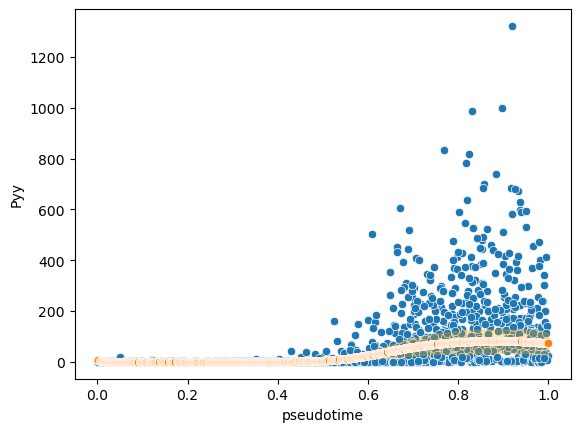

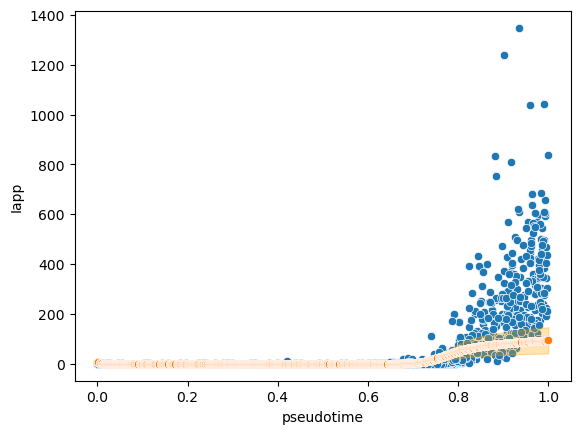

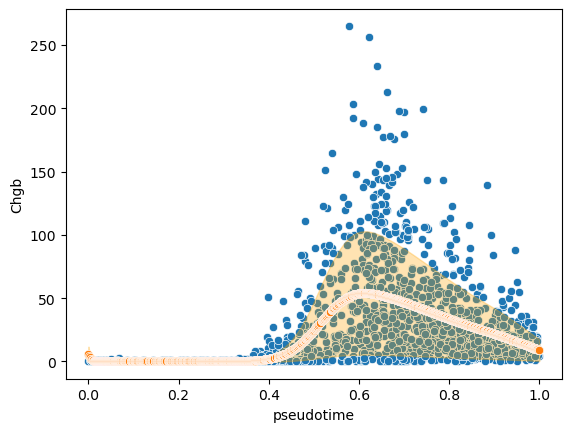

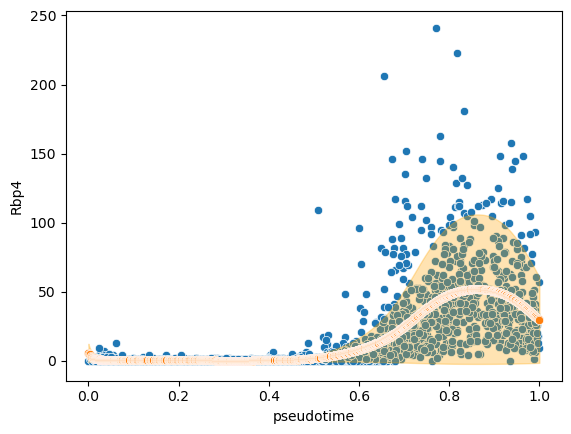

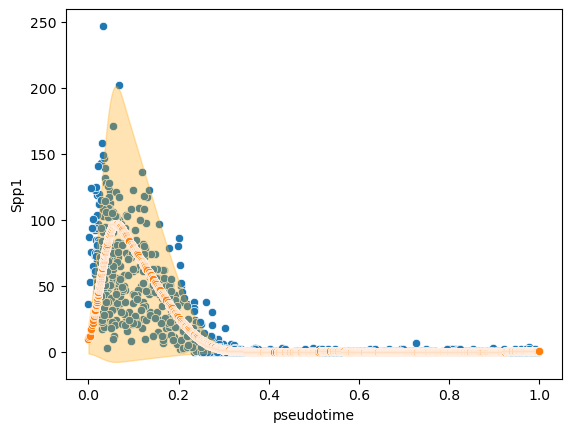

In [6]:
for i in range(5):
    plot_gene(sim, example_sce, i)
    plt.show()

In [7]:
fmla = {"mean": "~ bs(pseudotime, df=10)", "dispersion": "~ bs(pseudotime, df=4)"}
sim.fit(example_sce, fmla)

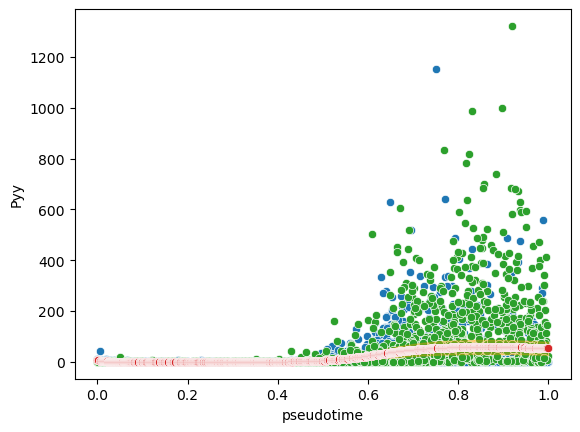

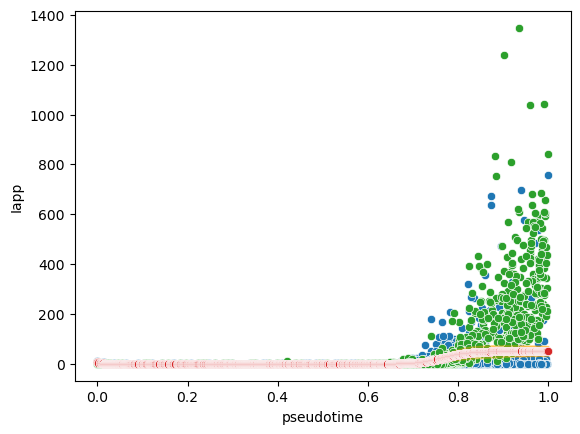

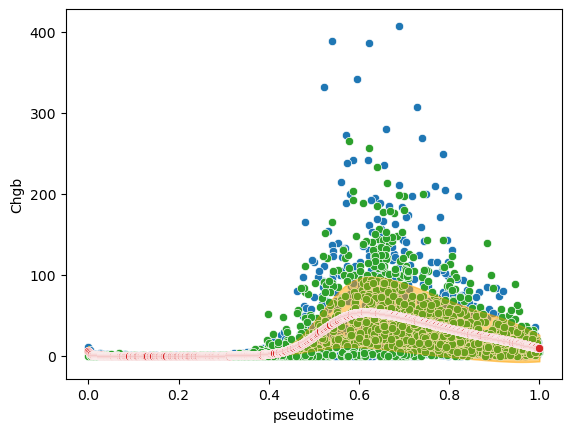

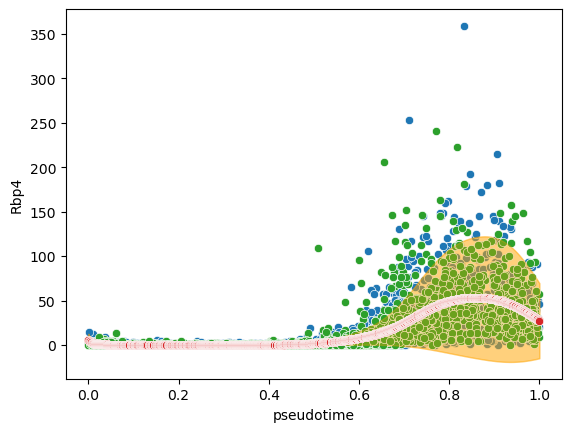

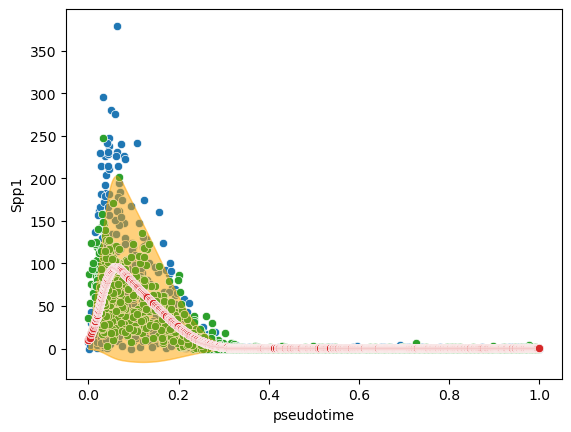

In [8]:
for i in range(5):
    plot_gene(sim, sim.sample(example_sce.obs), i)
    plot_gene(sim, example_sce, i)
    plt.show()

In [9]:
import altair as alt
import pandas as pd

sampled = sim.sample(example_sce.obs)
X = pd.DataFrame(np.log(1 + sampled.X), columns=sampled.var_names)

sampled_subset = pd.concat([X.iloc[:, :5], sampled.obs], axis=1)
alt.Chart(sampled_subset).mark_circle(opacity=1, size=1).encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative')
).properties(width=40, height=40).repeat(
    row=sampled_subset.columns[:5],
    column=sampled_subset.columns[:5]
).configure_axis(labelFontSize=9, titleFontSize=9)

alt.RepeatChart(...)

Here is a version of a copula that has a different covariance for each cell type.

In [10]:
sim = NegBinCopulaSimulator()
sim.fit(example_sce, "~ pseudotime", copula_groups="cell_type")
print(sim.params["covariance"]["Ngn3 low EP"].iloc[:2, :2])
print(sim.params["covariance"]["Beta"].iloc[:2, :2])

sim.sample(example_sce.obs)

           Pyy      Iapp
Pyy   0.383833  0.027396
Iapp  0.027396  0.635198
           Pyy      Iapp
Pyy   0.586671  0.069107
Iapp  0.069107  0.593025


AnnData object with n_obs × n_vars = 2087 × 100
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'cell_type', 'sizeFactor', 'pseudotime', '_copula_group'

# Poisson

In [11]:
from scdesigner.simulators import PoissonCopulaSimulator

sim = PoissonCopulaSimulator(lr=0.1)
sim.fit(example_sce, "~ pseudotime")
sim

scDesigner simulator object with
    method: PoissonCopulaSimulator
    formula: ~ pseudotime
    parameters: coef_beta [2x100], covariance [100x100]

In [12]:
def plot_gene(sim, example_sce, ix=0):
    # get predictions
    gene = example_sce.var_names[ix]
    y_hat = sim.predict(example_sce.obs)["mean"]
    variance = y_hat

    # build confidence bands
    y_hat["pseudotime"] = example_sce.obs["pseudotime"].values
    y_hat["lower_sd"] = y_hat[gene].values - np.sqrt(variance[gene].values)
    y_hat["upper_sd"] = y_hat[gene].values + np.sqrt(variance[gene].values) 

    # plot
    y_hat = y_hat.sort_values(by="pseudotime")
    sns.scatterplot(x="pseudotime", y=gene, data={"pseudotime": example_sce.obs["pseudotime"], gene: example_sce.X[:, ix]})
    plt.fill_between(y_hat['pseudotime'], y_hat['lower_sd'], y_hat['upper_sd'], color='orange', alpha=0.3)
    sns.scatterplot(x="pseudotime", y=gene, data=y_hat)

In [13]:
sim.predict(example_sce.obs).keys()

dict_keys(['mean'])

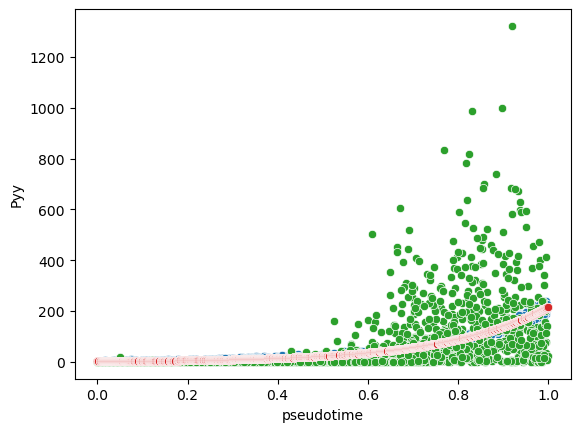

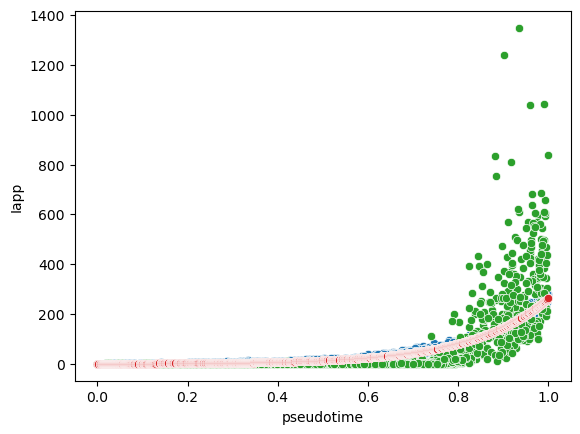

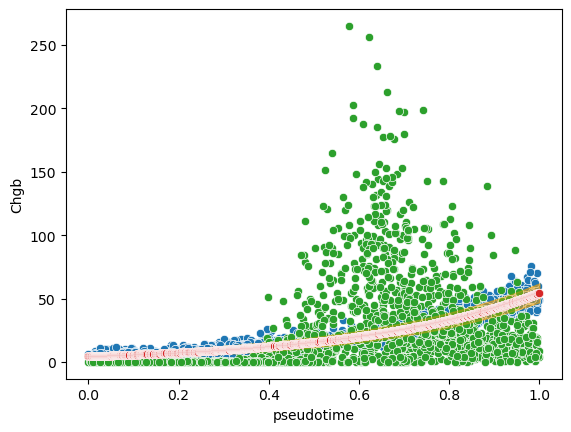

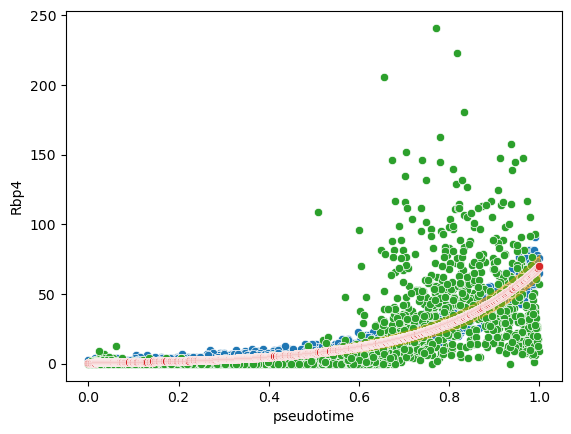

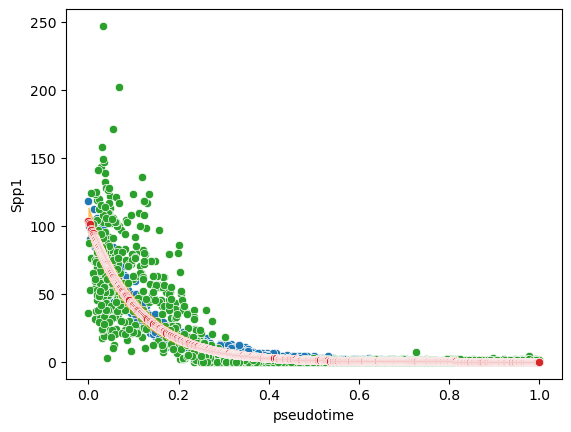

In [14]:
for i in range(5):
    plot_gene(sim, sim.sample(example_sce.obs), i)
    plot_gene(sim, example_sce, i)
    plt.show()

In [15]:
# plotting correlation of simulated data
sampled = sim.sample(example_sce.obs)
X = pd.DataFrame(np.log(1 + sampled.X), columns=sampled.var_names)

sampled_subset = pd.concat([X.iloc[:, :5], sampled.obs], axis=1)
alt.Chart(sampled_subset).mark_circle(opacity=1, size=1).encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative')
).properties(width=40, height=40).repeat(
    row=sampled_subset.columns[:5],
    column=sampled_subset.columns[:5]
).configure_axis(labelFontSize=9, titleFontSize=9)

alt.RepeatChart(...)

# Bernoulli

In [16]:
from scdesigner.simulators import BernoulliCopulaSimulator

In [17]:
# would need to download this data first
save_path = "data/multiomic_methylation.h5ad"
multi = anndata.read_h5ad(save_path)
multi.X

array([[1., 1., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 1., 1.]], shape=(142, 27))

In [18]:
import numpy as np

sim = BernoulliCopulaSimulator()
sim.fit(multi, "~ bs(X1, df=3)")
sim

scDesigner simulator object with
    method: BernoulliCopulaSimulator
    formula: ~ bs(X1, df=3)
    parameters: coef_mean [4x27], covariance [27x27]

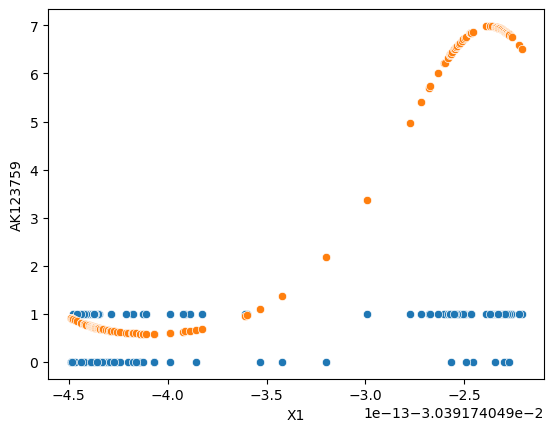

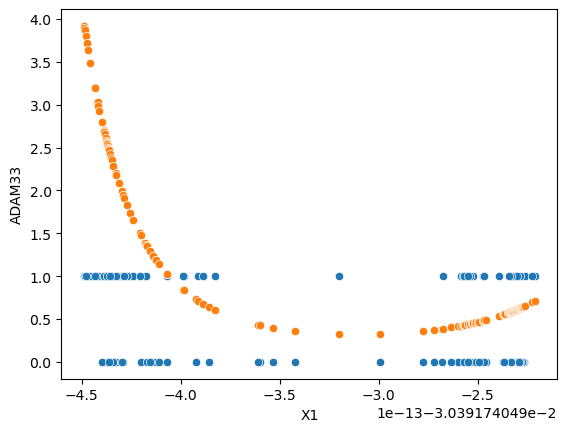

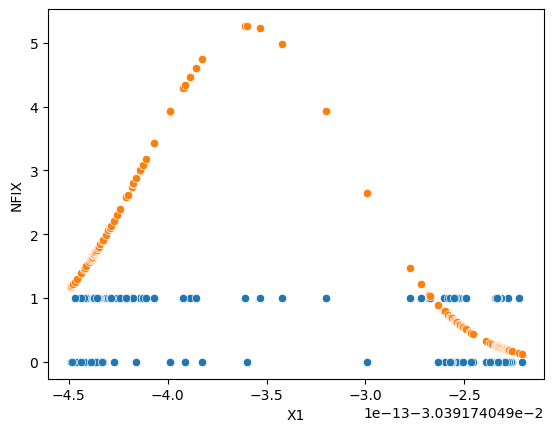

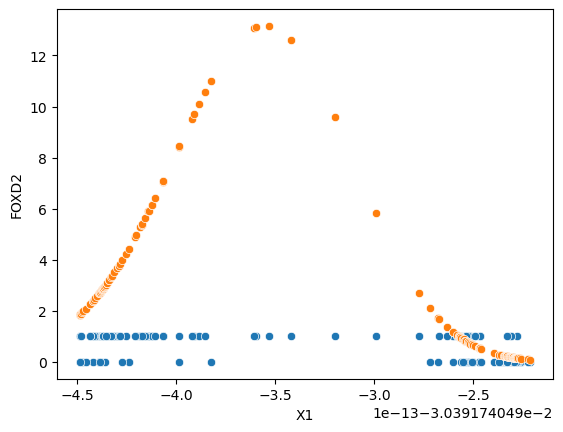

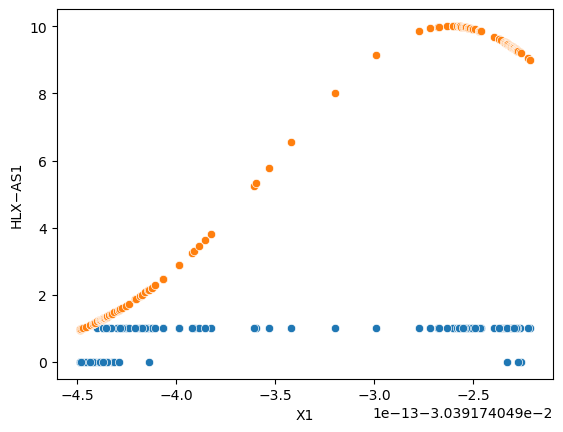

In [19]:
# plots predicted p
def plot_gene(sim, example_sce, ix=0, var="pseudotime"):
    # get predictions
    gene = example_sce.var_names[ix]
    y_hat = sim.predict(example_sce.obs)["mean"]
    y_hat[var] = example_sce.obs[var].values

    # plot
    y_hat = y_hat.sort_values(by=var)
    sns.scatterplot(x=var, y=gene, data={var: example_sce.obs[var], gene: example_sce.X[:, ix]})
    sns.scatterplot(x=var, y=gene, data=y_hat)

for i in range(5):
    plot_gene(sim, multi, i, "X1")
    plt.show()

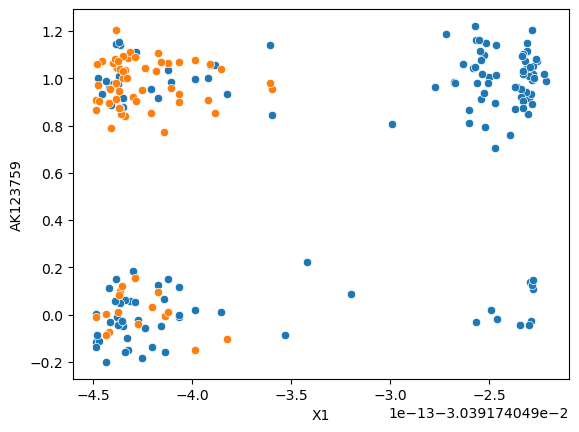

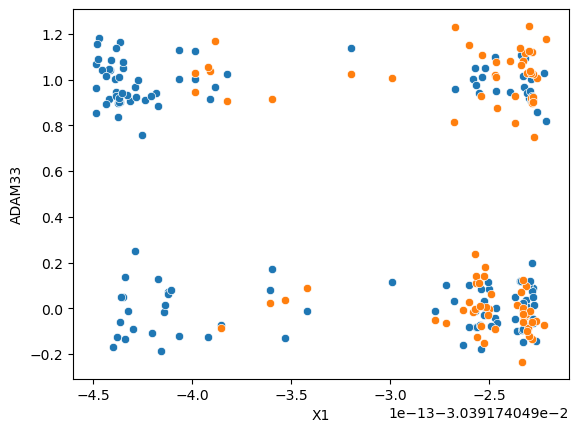

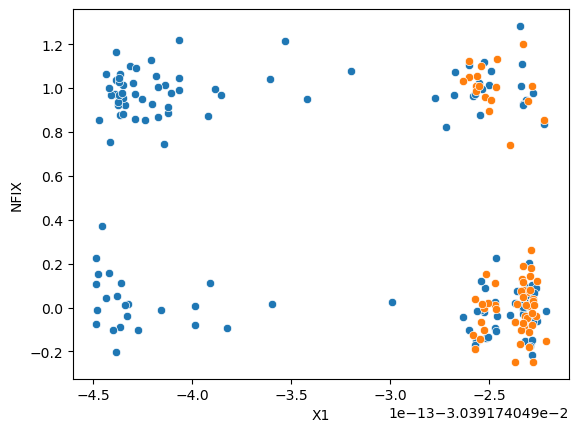

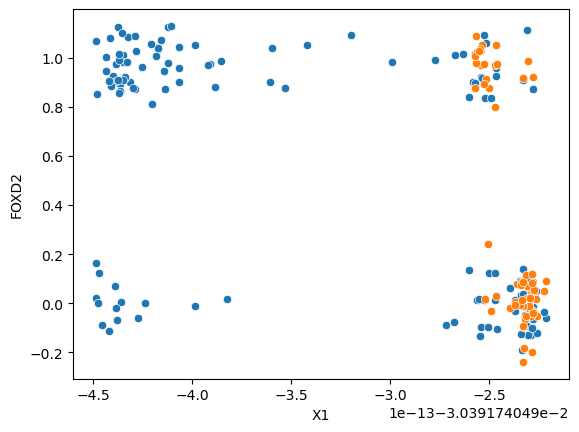

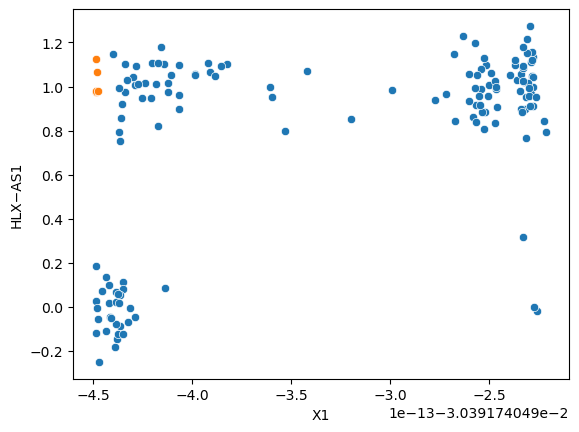

In [22]:
# compare real vs simulated data
def plot_gene(sim, example_sce, ix=0, var="pseudotime"):
    # get predictions
    gene = example_sce.var_names[ix]
    sampled = sim.sample(example_sce.obs)

    jitter_real = example_sce.X + np.random.normal(0,0.1,example_sce.X.shape)
    jitter_sim = sampled.X + np.random.normal(0,0.1,sampled.X.shape)
    
    # plot
    sns.scatterplot(x=var, y=gene, data={var: example_sce.obs[var], gene: jitter_real[:, ix]})
    sns.scatterplot(x=var, y=gene, data={var: example_sce.obs[var], gene: jitter_sim[:, ix]})

for i in range(5):
    plot_gene(sim, multi, i, "X1")
    plt.show()
